In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
tf.random.set_seed(2401)
from sklearn.preprocessing import StandardScaler


2023-08-29 17:42:18.065483: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
train = pd.read_csv('/Users/inesmurcortes/Documents/GitHub/Spaceship_Titanic/train.csv')
test = pd.read_csv('/Users/inesmurcortes/Documents/GitHub/Spaceship_Titanic/test.csv')

df = train

In [477]:
df.head()
#df.describe()
#df.info()
#df.nunique()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [478]:
# First I would like to have a little bit of information about the type of the variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [479]:
# Now I would like to know about unique values. 
# PassengerId has many different values and it's not interesting, so I will not keep it.
# It happens the same with Name, so I will not keep it either. 

df.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

In [480]:
# I drop Name thus is not an interesting variable
df.drop(['Name'], axis=1, inplace=True)

In [481]:
# Then I will continue by changing the category of some of the variables that are not correct, changing them to 'category'

to_factor = list(df.loc[:, df.nunique()<10])
df[to_factor] = df[to_factor].astype('category')

In [482]:
# Now I describe the categorical variables. I see some points that I would like to inspect a little bit more.
df.describe(exclude=np.number)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Transported
count,8693,8492,8476,8494,8511,8490,8693
unique,8693,3,2,6560,3,2,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,True
freq,1,4602,5439,8,5915,8291,4378


In [483]:
# Now I describe the numberical values, where I can see the great range of most of the variables. 
df.describe(include=np.number)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [484]:
# Now I use some functions to plot the data depending on whether they are categorical or not
def histogram_boxplot(data, xlabel=None, title=None, font_scale=2, figsize=(9, 8), bins=None):

    # Define font size
    sns.set(font_scale=font_scale)
    # Create subplots for boxplot and histogram
    f2, (ax_box2, ax_hist2) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=figsize)
    # Check if data is numeric
    if data.dtype.kind in 'biufc':
        # Create boxplot
        sns.boxplot(x=data, ax=ax_box2)
    else:
        ax_box2.axis('off')  # Turn off boxplot axes if data is not numeric

    # Create histogram
    sns.histplot(x=data, ax=ax_hist2, bins=bins) if bins else sns.histplot(x=data, ax=ax_hist2)
    # Plot a line for the mean
    ax_hist2.axvline(np.mean(data), color='g', linestyle='-')
    # Plot a line for the median
    ax_hist2.axvline(np.median(data), color='y', linestyle='--')
    # Set xlabel and title if provided
    if xlabel:
        ax_hist2.set(xlabel=xlabel)
    if title:
        ax_box2.set(title=title, xlabel="")
    # Show histogram
    plt.show()

def cat_plot(col):
     if col.dtypes == 'category':
        fig = px.bar(col.value_counts())
        #fig = sns.countplot(x=col)
        return(fig)
    
def plot(col):
    if col.dtypes != 'category':
        print('Cont')
        histogram_boxplot(col, xlabel = col.name, title = 'Distibución continua')
    else:
        print('Cat')
        cat_plot(col)


In [165]:
# After a lot of troublshooting, I find out that there is an error on this code when applying to column 'Cabin'. 
# I will study it in depth later on.

df_plot = df.drop(['Cabin', 'PassengerId'], axis=1)

Cat
Cat
Cat
Cont


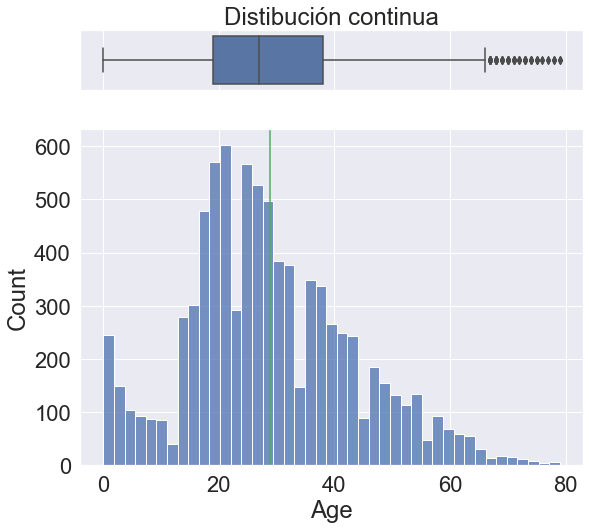

Cat
Cont


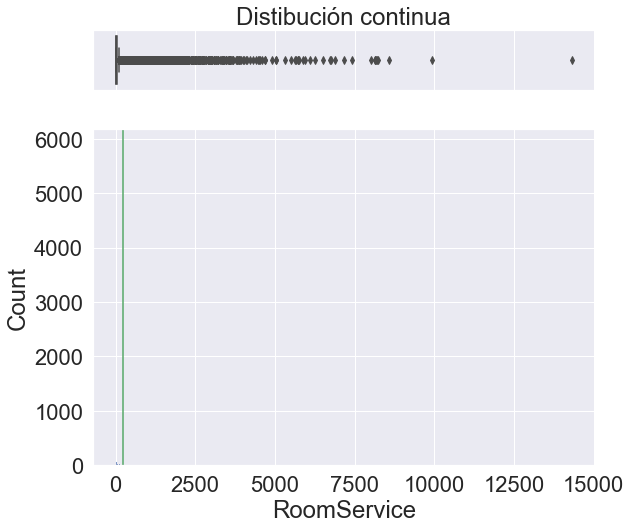

Cont


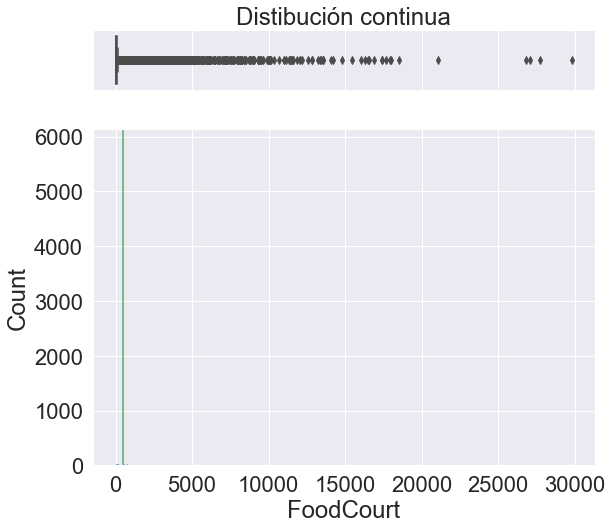

Cont


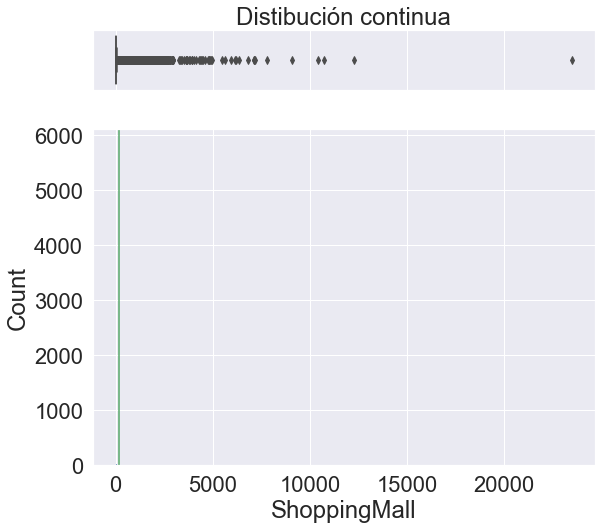

Cont


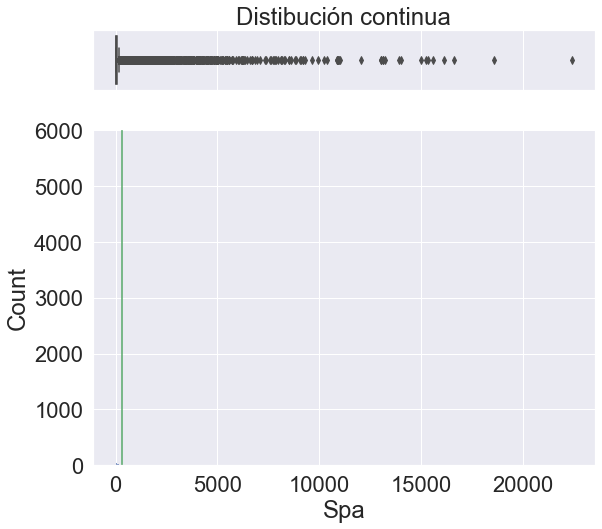

Cont


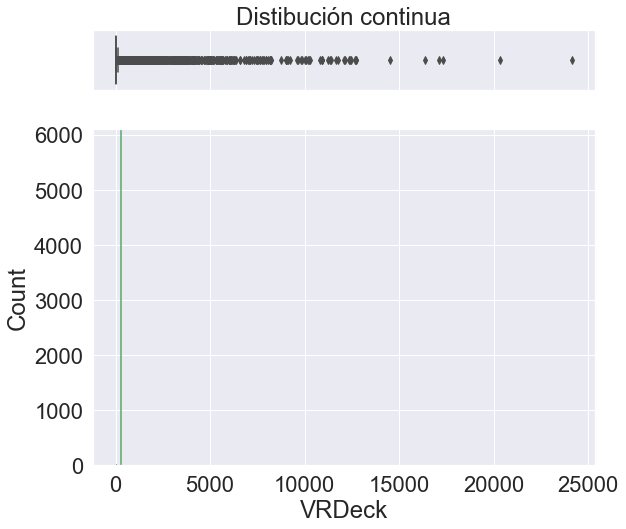

Cat


HomePlanet      None
CryoSleep       None
Destination     None
Age             None
VIP             None
RoomService     None
FoodCourt       None
ShoppingMall    None
Spa             None
VRDeck          None
Transported     None
dtype: object

In [167]:
df_plot.iloc[:,:].apply(plot)

In [ ]:
cat_plot(df.VIP)

In [ ]:
cat_plot(df.CryoSleep)

In [ ]:
cat_plot(df.HomePlanet)

In [ ]:
cat_plot(df.Destination)

### Conclusions ###

1. Categorical variables: The visual study that I made about the categorical data shows that most of the variables are imbalanced.
    * VIP is a very imbalanced variable, with almost 2% of the passengers being VIP.
    * CryoSleep balanced, with 55% of the passengers being on CryoSleep during the trip.
    * Most of the passengers are from the Earth (54%), while the other two categories (Europa and Mars) are similar.
    * Destination is more imbalaced than HomePlanet. Most of the passengers are heading to TRAPIST-1e (67%), but the other two minor categories are also imbalanced, being 55 Cancri e the next most popular destination.

2. Numercial variables: The visual study shows that most of the variables don't follow a normal distribution, besides 'Age' which mean is 28 years of age. The visual studio and the quantitative studio suggests that the range of the variables is way too large and there is presence of outliers. 

3. The variable 'Cabin' is composed by Deck / Num / Side, so I will divide the variable into three different ones in order to study passengers location more accurately. 

4. The variable 'PassengerID' is composed by Group Number and their Position within that group, so I will split the variable into two different ones. Just like 'Cabin'.

In [485]:
df.Cabin = df.Cabin.fillna('00/00/00')

In [486]:
split_values = df.Cabin.str.split('/', expand=True)
split_values = split_values.rename(columns={0:'Cabin_Deck', 1:'Cabin_Number', 2:'Cabin_Side'})

In [487]:
df = df.join(split_values)
df.drop('Cabin', axis=1, inplace=True)

In [489]:
split_values = df.PassengerId.str.split('_', expand=True)
split_values = split_values.rename(columns={0:'Passenger_Group', 1:'Passenger_Number'})

In [490]:
df = df.join(split_values)
df.drop('PassengerId', axis=1, inplace=True)

In [491]:
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_Deck,Cabin_Number,Cabin_Side,Passenger_Group,Passenger_Number
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P,0001,01
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S,0002,01
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S,0003,01
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S,0003,02
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S,0004,01


# Variable Cleaning

## Outliers Analysis

In [492]:
# To asses the incidence of outliers, first I create a list of all countinuous variables and make a copy.
col_cont = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df_cont = df[col_cont].copy()

In [493]:
## Winsor clip+pandas
def winsorize_with_pandas(s, limits):
    """
    s : pd.Series
        Series to winsorize
    limits : tuple of float
        Tuple of the percentages to cut on each side of the array, 
        with respect to the number of unmasked data, as floats between 0. and 1
    """
    return s.clip(lower=s.quantile(limits[0], interpolation='lower'), 
                  upper=s.quantile(1-limits[1], interpolation='higher'))

## Manage outliers
def gestiona_outliers(col,clas = 'check'):
    
     print(col.name)
     # Condición de asimetría y aplicación de criterio 1 según el caso
     if abs(col.skew()) < 1:
        criterio1 = abs((col-col.mean())/col.std())>3
     else:
        criterio1 = abs((col-col.median())/col.mad())>8
     
     # Calcular primer cuartil     
     q1 = col.quantile(0.25)  
     # Calcular tercer cuartil  
     q3 = col.quantile(0.75)
     # Calculo de IQR
     IQR=q3-q1
     # Calcular criterio 2 (general para cualquier asimetría)
     criterio2 = (col<(q1 - 3*IQR))|(col>(q3 + 3*IQR))
     lower = col[criterio1&criterio2&(col<q1)].count()/col.dropna().count()
     upper = col[criterio1&criterio2&(col>q3)].count()/col.dropna().count()
     # Salida según el tipo deseado
     if clas == 'check':
            return(lower*100,upper*100,(lower+upper)*100)
     elif clas == 'winsor':
            return(winsorize_with_pandas(col,(lower,upper)))
     elif clas == 'miss':
            print('\n MissingAntes: ' + str(col.isna().sum()))
            col.loc[criterio1&criterio2] = np.nan
            print('MissingDespues: ' + str(col.isna().sum()) +'\n')
            return(col)

          
# Check-Mode Calling Function
df_cont.select_dtypes(include=np.number).copy().apply(lambda x: gestiona_outliers(x))

Age
RoomService
FoodCourt
ShoppingMall
Spa
VRDeck


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000
1,0.0,1.233553,1.73913,1.166765,1.903643,1.857731
2,0.0,1.233553,1.73913,1.166765,1.903643,1.857731


In [494]:
# While having very skewed variables and a low outliers incidence, I have decided to winsorize the outliers.
df_cont_winsor = df_cont.apply(lambda x: gestiona_outliers(x,clas='winsor'))

Age
RoomService
FoodCourt
ShoppingMall
Spa
VRDeck


In [495]:
# I check the correct use of the winsorize function on ShoppingMall variable
df_cont_winsor.sort_values(by='ShoppingMall', ascending=False).head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
1572,38.0,158.0,787.0,2184.0,NaN,86.0
3881,58.0,0.0,279.0,2184.0,122.0,30.0
5673,36.0,0.0,1828.0,2184.0,1.0,2.0
5137,15.0,0.0,22.0,2184.0,0.0,531.0
6223,13.0,0.0,100.0,2184.0,6.0,80.0


## Missings Analysis

In [496]:
# I join the DF with the winsorized variables and the categorical variables that I saved before
df_winsor = df_cont_winsor.join(df.select_dtypes(exclude=np.number))

In [497]:
# I inspect the incidence of missings and I find out is very low (slightly above 2%) 
df_winsor.apply(lambda x: x.isna().sum()/x.count()*100)

Age                 2.102420
RoomService         2.126410
FoodCourt           2.150411
ShoppingMall        2.451385
Spa                 2.150411
VRDeck              2.210464
HomePlanet          2.366934
CryoSleep           2.560170
Destination         2.138409
VIP                 2.391048
Transported         0.000000
Cabin_Deck          0.000000
Cabin_Number        0.000000
Cabin_Side          0.000000
Passenger_Group     0.000000
Passenger_Number    0.000000
dtype: float64

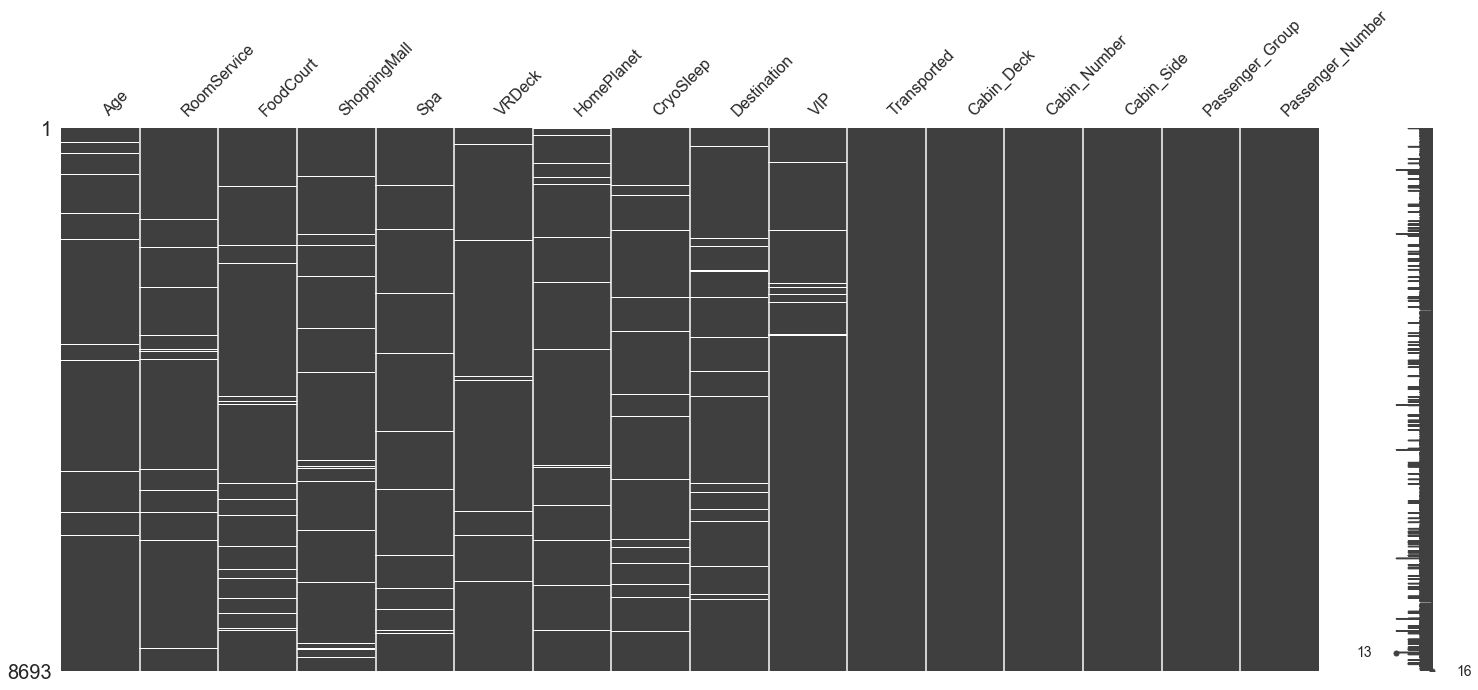

In [498]:
# I inspect the abscence or not of a random pattern of missing values. 
# Apparently is random.

import missingno as msno   

# Plot correlation heatmap of missingness by objetive variable
msno.matrix(df_winsor.sort_values(by='Transported'))

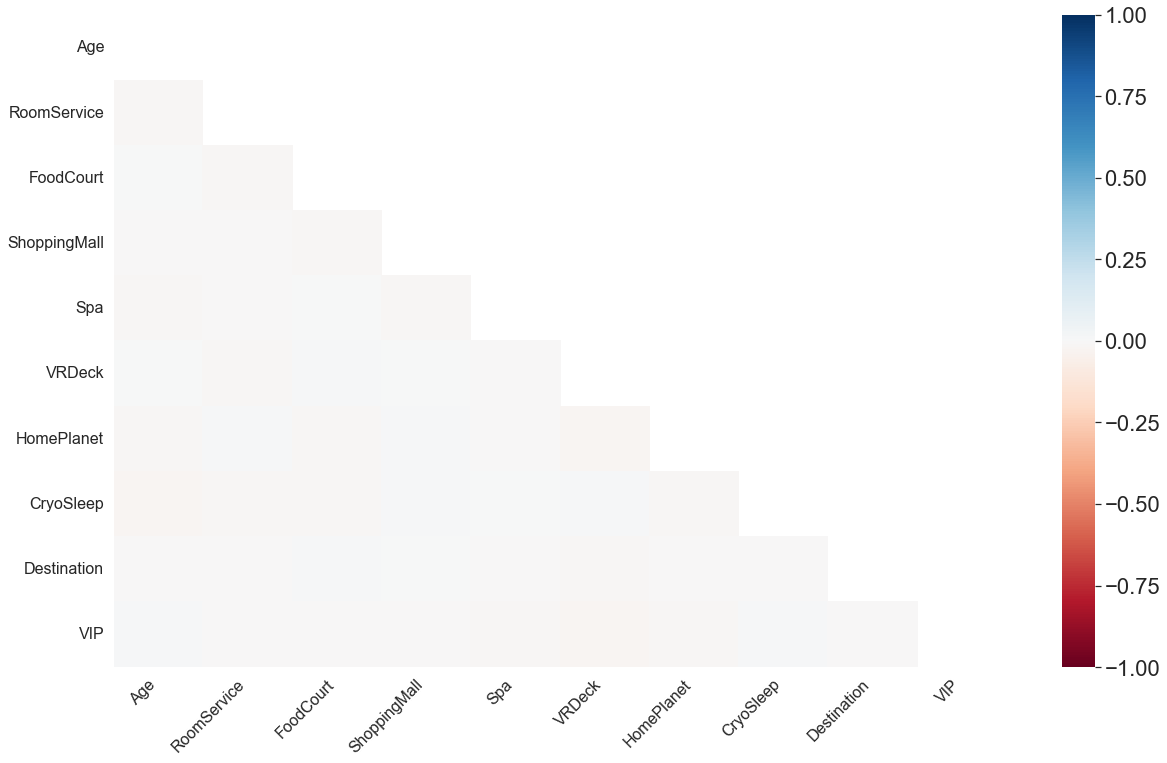

In [499]:
msno.heatmap(df_winsor)

In [500]:
# I split the DF in two (categorical and numeric) and drop the Target Variable in order to treat the missing values

df_winsor_cont = df_winsor.select_dtypes(include = np.number)
df_winsor_cate = df_winsor.select_dtypes(exclude = np.number)
df_winsor_cate = df_winsor_cate.drop('Transported', axis=1)

In [501]:
import sklearn.impute as skl_imp
from sklearn.experimental import enable_iterative_imputer

# I create an imputer for categorical variables. I will use the mode (most frequent) for the imputation of missings
imputer_moda = skl_imp.SimpleImputer(strategy='most_frequent', missing_values=np.nan)

# I create an imputer for numercial variables. I will use the KNN of 3 nearest neighbours for the imputation of missings
imputer_knn = skl_imp.KNNImputer(n_neighbors=3)

In [502]:
# I apply them to the DF I have created before
df_wins_knn_imputed = pd.DataFrame(imputer_knn.fit_transform(df_winsor_cont),columns=df_winsor_cont.columns)
imput_wins_moda_imputed = pd.DataFrame(imputer_moda.fit_transform(df_winsor_cate),columns=df_winsor_cate.columns)

In [503]:
# Check the incidence of NaN values, which is 0. The imputers worked correctly.
df_clean.isna().sum()

Age                 0
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
HomePlanet          0
CryoSleep           0
Destination         0
VIP                 0
Cabin_Deck          0
Cabin_Number        0
Cabin_Side          0
Passenger_Group     0
Passenger_Number    0
Transported         0
dtype: int64

In [504]:
# I join everything i a new DF (categorical, numeric and Target) and then I save it
df_clean = df_wins_knn_imputed.join(imput_wins_moda_imputed)
df_clean = df_clean.join(df['Transported'])

In [505]:
df_clean.to_csv('/Users/inesmurcortes/Documents/inés/GitHub_Titanic/Spaceship_Titanic/Train_Clean.csv', mode='w', index=False)

## Test DF Cleaning Process

In [506]:
test = pd.read_csv('/Users/inesmurcortes/Documents/inés/GitHub_Titanic/Spaceship_Titanic/test.csv')

In [507]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [508]:
test.drop(['Name'], axis=1, inplace=True)

In [509]:
to_factor = list(test.loc[:, test.nunique()<10])
test[to_factor] = test[to_factor].astype('category')

In [510]:
test.Cabin = test.Cabin.fillna('00/00/00')
split_values = test.Cabin.str.split('/', expand=True)
split_values = split_values.rename(columns={0:'Cabin_Deck', 1:'Cabin_Number', 2:'Cabin_Side'})

In [511]:
test = test.join(split_values)
test.drop('Cabin', axis=1, inplace=True)

In [512]:
split_values = test.PassengerId.str.split('_', expand=True)
split_values = split_values.rename(columns={0:'Passenger_Group', 1:'Passenger_Number'})

In [513]:
test = test.join(split_values)
test.drop('PassengerId', axis=1, inplace=True)

In [514]:
col_to_keep = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
test_cont = test[col_to_keep].copy()

In [515]:
test_cont.select_dtypes(include=np.number).copy().apply(lambda x: gestiona_outliers(x))

Age
RoomService
FoodCourt
ShoppingMall
Spa
VRDeck


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
1,0.0,1.02503,2.013906,1.411821,1.772031,1.810817
2,0.0,1.02503,2.013906,1.411821,1.772031,1.810817


In [516]:
test_cont_winsor = test_cont.apply(lambda x: gestiona_outliers(x,clas='winsor'))

Age
RoomService
FoodCourt
ShoppingMall
Spa
VRDeck


In [517]:
test_winsor = test_cont_winsor.join(test.select_dtypes(exclude=np.number))

In [518]:
test_winsor.apply(lambda x: x.isna().sum()/x.count()*100)

Age                 2.173913
RoomService         1.954708
FoodCourt           2.541357
ShoppingMall        2.345059
Spa                 2.418582
VRDeck              1.906123
HomePlanet          2.076372
CryoSleep           2.222753
Destination         2.198327
VIP                 2.222753
Cabin_Deck          0.000000
Cabin_Number        0.000000
Cabin_Side          0.000000
Passenger_Group     0.000000
Passenger_Number    0.000000
dtype: float64

In [519]:
test_winsor_cont = test_winsor.select_dtypes(include = np.number)
test_winsor_cate = test_winsor.select_dtypes(exclude = np.number)

In [520]:
imputer_moda_test = skl_imp.SimpleImputer(strategy='most_frequent', missing_values=np.nan)
imputer_knn_test = skl_imp.KNNImputer(n_neighbors=3)

In [521]:
test_wins_knn_imputed = pd.DataFrame(imputer_knn_test.fit_transform(test_winsor_cont),columns=test_winsor_cont.columns)
test_imput_wins_moda_imputed = pd.DataFrame(imputer_moda_test.fit_transform(test_winsor_cate),columns=test_winsor_cate.columns)

In [522]:
test_clean = test_wins_knn_imputed.join(test_imput_wins_moda_imputed)

In [523]:
test_clean.isnull().sum()

Age                 0
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
HomePlanet          0
CryoSleep           0
Destination         0
VIP                 0
Cabin_Deck          0
Cabin_Number        0
Cabin_Side          0
Passenger_Group     0
Passenger_Number    0
dtype: int64

In [524]:
test_clean.to_csv('/Users/inesmurcortes/Documents/inés/GitHub_Titanic/Spaceship_Titanic/Test_Clean.csv', mode='w', index=False)

## Training Models with Neural Networks

In [525]:
ctrain = pd.read_csv('/Users/inesmurcortes/Documents/inés/GitHub_Titanic/Spaceship_Titanic/Train_Clean.csv')
ctest = pd.read_csv('/Users/inesmurcortes/Documents/inés/GitHub_Titanic/Spaceship_Titanic/Test_Clean.csv')

In [527]:
ctrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               8693 non-null   float64
 1   RoomService       8693 non-null   float64
 2   FoodCourt         8693 non-null   float64
 3   ShoppingMall      8693 non-null   float64
 4   Spa               8693 non-null   float64
 5   VRDeck            8693 non-null   float64
 6   HomePlanet        8693 non-null   object 
 7   CryoSleep         8693 non-null   bool   
 8   Destination       8693 non-null   object 
 9   VIP               8693 non-null   bool   
 10  Cabin_Deck        8693 non-null   object 
 11  Cabin_Number      8693 non-null   int64  
 12  Cabin_Side        8693 non-null   object 
 13  Passenger_Group   8693 non-null   int64  
 14  Passenger_Number  8693 non-null   int64  
 15  Transported       8693 non-null   bool   
dtypes: bool(3), float64(6), int64(3), object(4

In [528]:
# In order to use an encoder for non numerical values, I store them in a list
categorical_columns = ctrain.select_dtypes(include=['object', 'bool']).columns.tolist()
categorical_columns

['HomePlanet',
 'CryoSleep',
 'Destination',
 'VIP',
 'Cabin_Deck',
 'Cabin_Side',
 'Transported']

In [529]:
encoder = LabelEncoder()

# I apply Label Encoding to categorical columns
ctrain[categorical_columns] = ctrain[categorical_columns].apply(encoder.fit_transform)

In [530]:
ctrain.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet,CryoSleep,Destination,VIP,Cabin_Deck,Cabin_Number,Cabin_Side,Passenger_Group,Passenger_Number,Transported
0,39.0,0.0,0.0,0.0,0.0,0.0,1,0,2,0,2,0,1,1,1,0
1,24.0,109.0,9.0,25.0,549.0,44.0,0,0,2,0,6,0,2,2,1,1
2,58.0,43.0,3576.0,0.0,3926.0,49.0,1,0,2,1,1,0,2,3,1,0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,1,0,2,0,1,0,2,3,2,0
4,16.0,303.0,70.0,151.0,565.0,2.0,0,0,2,0,6,1,2,4,1,1


### Pretesting the models with Train DF

In [531]:
# I'm going to work with X and Y from the Train dataset to first know how the model is responding
X = ctrain.drop('Transported', axis=1)
y = ctrain.pop('Transported')

# I will use a 20% of the train DF as my test DF
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1965)

In [532]:
model = tf.keras.models.Sequential()

input_dim = X_train.shape[1]

model.add(layers.Dense(units=128, activation='relu', input_dim=input_dim))
model.add(layers.Dense(units=564, activation='relu'))
model.add(layers.Dense(units=564, activation='relu'))
model.add(layers.Dense(units=128, activation='relu'))

model.add(layers.Dense(units=1, activation='sigmoid'))

es_callback = keras.callbacks.EarlyStopping(
    monitor='accuracy', 
    patience=15,  # if during 15 epochs there is no improvement in `val_loss`, the execution will stop
    verbose=1)

In [633]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics=['accuracy']
)
model.fit(X_train, 
          y_train, 
          epochs=250, 
          validation_split = 0.2, 
          batch_size=64,
          callbacks = [es_callback])

NameError: name 'X_train_processed_2' is not defined

In [534]:
results = model.evaluate(X_train, y_train, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.4487501084804535
Test Accuracy: 0.8016968369483948


### Testing the final model with Test DF and Kaggle 

In [586]:
train = pd.read_csv('/Users/inesmurcortes/Documents/inés/GitHub_Titanic/Spaceship_Titanic/Train_Clean.csv')
test = pd.read_csv('/Users/inesmurcortes/Documents/inés/GitHub_Titanic/Spaceship_Titanic/Test_Clean.csv')

In [587]:
X_train = train.drop(['Transported'], axis=1)
y_train = train.pop('Transported')

X_test = test
y_test = None

In [588]:
# Finally, I will apply the model i defined before and apply to the Test DF
categorical_columns = X_test.select_dtypes(include=['object', 'bool']).columns.tolist()
categorical_columns

['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin_Deck', 'Cabin_Side']

In [589]:
encoder = LabelEncoder()

# I apply Label Encoding to categorical columns in X_test and X_train
X_test[categorical_columns] = X_test[categorical_columns].apply(encoder.fit_transform)
X_train[categorical_columns] = X_train[categorical_columns].apply(encoder.fit_transform)

In [590]:
y_train.replace({True:1, False:0}, inplace=True)

In [591]:
y_train.head()

0    0
1    1
2    0
3    0
4    1
Name: Transported, dtype: int64

In [592]:
print('x_train, y_train shapes:', X_train.shape, y_train.shape)
print('x_test, y_test shapes:', X_test.shape)
print('Some qualities: ', y_train[:5])

x_train, y_train shapes: (8693, 15) (8693,)
x_test, y_test shapes: (4277, 15)
Some qualities:  0    0
1    1
2    0
3    0
4    1
Name: Transported, dtype: int64


In [615]:
model = tf.keras.models.Sequential()

input_dim = X_train.shape[1]

model.add(layers.Dense(units=64, activation='relu', input_dim=input_dim))
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dense(units=32, activation='relu'))

model.add(layers.Dense(units=1, activation='sigmoid'))

es_callback = keras.callbacks.EarlyStopping(
    monitor='accuracy', 
    patience=15,  # if during 15 epochs there is no improvement in `val_loss`, the execution will stop
    verbose=1)

In [616]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics=['accuracy']
)
model.fit(X_train, 
          y_train, 
          epochs=250, 
          validation_split = 0.2, 
          batch_size=64,
          callbacks = [es_callback])

Epoch 1/250
109/109 [==============================] - 1s 2ms/step - loss: 9.0509 - accuracy: 0.6917 - val_loss: 1.4482 - val_accuracy: 0.7372
Epoch 2/250
109/109 [==============================] - 0s 2ms/step - loss: 2.4614 - accuracy: 0.6938 - val_loss: 1.6526 - val_accuracy: 0.7447
Epoch 3/250
109/109 [==============================] - 0s 2ms/step - loss: 1.2716 - accuracy: 0.7115 - val_loss: 2.2348 - val_accuracy: 0.6095
Epoch 4/250
109/109 [==============================] - 0s 2ms/step - loss: 1.4097 - accuracy: 0.7110 - val_loss: 1.1833 - val_accuracy: 0.7079
Epoch 5/250
109/109 [==============================] - 0s 2ms/step - loss: 1.0189 - accuracy: 0.7258 - val_loss: 0.9611 - val_accuracy: 0.7746
Epoch 6/250
109/109 [==============================] - 0s 2ms/step - loss: 0.8699 - accuracy: 0.7403 - val_loss: 1.2717 - val_accuracy: 0.7269
Epoch 7/250
109/109 [==============================] - 0s 2ms/step - loss: 1.0129 - accuracy: 0.7245 - val_loss: 3.0509 - val_accuracy: 0.5957

Epoch 58/250
109/109 [==============================] - 0s 1ms/step - loss: 0.4581 - accuracy: 0.7877 - val_loss: 0.4941 - val_accuracy: 0.7821
Epoch 59/250
109/109 [==============================] - 0s 1ms/step - loss: 0.4569 - accuracy: 0.7912 - val_loss: 0.5236 - val_accuracy: 0.7608
Epoch 60/250
109/109 [==============================] - 0s 1ms/step - loss: 0.4531 - accuracy: 0.7915 - val_loss: 0.5119 - val_accuracy: 0.7706
Epoch 61/250
109/109 [==============================] - 0s 1ms/step - loss: 0.4398 - accuracy: 0.7941 - val_loss: 0.4920 - val_accuracy: 0.7809
Epoch 62/250
109/109 [==============================] - 0s 1ms/step - loss: 0.4606 - accuracy: 0.7850 - val_loss: 0.4836 - val_accuracy: 0.7941
Epoch 63/250
109/109 [==============================] - 0s 1ms/step - loss: 0.4710 - accuracy: 0.7834 - val_loss: 0.5491 - val_accuracy: 0.7677
Epoch 64/250
109/109 [==============================] - 0s 2ms/step - loss: 0.4540 - accuracy: 0.7893 - val_loss: 0.4647 - val_accuracy:

In [617]:
predict = model.predict(X_test)

134/134 [==============================] - 0s 689us/step


In [618]:
predict = predict.flatten()
predict

array([9.9979120e-01, 1.1211921e-04, 9.7415960e-01, ..., 9.7242862e-01,
       5.8922035e-01, 8.0179119e-01], dtype=float32)

In [619]:
pred = []

for i in predict:
    if i == 1:
        pred.append(True)
    else:
        pred.append(False)

In [620]:
output2 = pd.DataFrame({'PassengerId':test['Passenger_Group'].astype('str').str.zfill(4)+'_'+test['Passenger_Number'].astype('str').str.zfill(2)
, 'Transported' : pred})

In [622]:
output2.to_csv('/Users/inesmurcortes/Documents/inés/GitHub_Titanic/Spaceship_Titanic/output2.csv', mode='w', index=False)